# Shakespeare ML

This is a dataset consisting of the complete works of Shakespeare. This dataset was created by Andrej Karpathy for <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'>this</a> blog post and is available on <a href='https://github.com/karpathy/char-rnn/blob/master/data/tinyshakespeare/input.txt'>this</a> github page.

## Imports

In [1]:
import matplotlib.pyplot as plt
import re
import tensorflow as tf
import tensorflow_datasets as tfds
import textwrap

## Helper Functions

In [25]:
def plot_training_metrics(history):
    plt.figure(facecolor=(1, 1, 1, 1), figsize=(12, 8)) # My notebook is in dark mode
    plt.subplot(1, 2, 1)
    plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.suptitle('Model Training')
    plt.legend()
    plt.show()

def save_best_model(model, test_ds, filename):
    try:
        saved_model = tf.keras.models.load_model(filename)
    except:
        saved_model = None

    if saved_model:
        print('Saved Model Evaluation:')
        saved_model_metrics = saved_model.evaluate(test_ds, return_dict=True)
        print('New Model Evaluation:')
        new_model_metrics = model.evaluate(test_ds, return_dict=True)
        if new_model_metrics['sparse_categorical_accuracy'] > saved_model_metrics['sparse_categorical_accuracy']:
            model.save(filename, save_traces=False)
    else:
        model.save(filename, save_traces=False)

## Character Based Approach

### Loading and Processing the Dataset

In [45]:
char_batch_size = 128
char_sequence_length = 100

AUTOTUNE = tf.data.AUTOTUNE

test_ds, train_ds, validation_ds = tfds.load('tiny_shakespeare', split=['test', 'train', 'validation'])
train_text = next(train_ds.as_numpy_iterator())['text'].decode()
print('Train Dataset Preview:')
print(textwrap.indent(train_text[:200], ' ' * 4))

vocab = sorted(set(train_text))
char_encoder = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=vocab
)
char_decoder = tf.keras.layers.experimental.preprocessing.StringLookup(
    invert=True,
    vocabulary=vocab
)
char_vocab_size = len(char_encoder.get_vocabulary())

def process_ds(ds):
    ds = ds.flat_map(lambda data: tf.data.Dataset.from_tensor_slices(char_encoder(tf.strings.unicode_split(data['text'], input_encoding='UTF-8'))))
    ds = ds.window(char_sequence_length+1, drop_remainder=True, shift=1)
    ds = ds.flat_map(lambda window: window.batch(char_sequence_length+1))
    ds = ds.map(lambda sequence: (sequence[:-1], sequence[-1]), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(char_batch_size)
    ds = ds.shuffle(1000)
    ds = ds.prefetch(AUTOTUNE)
    return ds

char_test_ds = process_ds(test_ds)
char_train_ds = process_ds(train_ds)
char_validation_ds = process_ds(validation_ds)

Train Dataset Preview:
    First Citizen:
    Before we proceed any further, hear me speak.

    All:
    Speak, speak.

    First Citizen:
    You are all resolved rather to die than to famish?

    All:
    Resolved. resolved.

    First Citizen:
    First, you


### Creating the Model

In [49]:
# Best Model (char_sequence_length=100)
# char_model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(
#         input_dim=char_vocab_size,
#         output_dim=64
#     ),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
#     tf.keras.layers.Dense(char_vocab_size)
# ])

char_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=char_vocab_size,
        output_dim=64
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)),
    tf.keras.layers.Dense(char_vocab_size)
])
char_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam()
)

### Training the Model

In [50]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    mode='max',
    monitor='val_sparse_categorical_accuracy',
    patience=3,
    restore_best_weights=True
)
char_history = char_model.fit(
    char_train_ds,
    callbacks=[early_stopping_callback],
    epochs=100,
    validation_data=char_validation_ds
)

Epoch 1/100
7842/7842 [==============================] - 861s 108ms/step - loss: 1.7087 - sparse_categorical_accuracy: 0.4974 - val_loss: 1.4893 - val_sparse_categorical_accuracy: 0.5558
Epoch 2/100
7842/7842 [==============================] - 859s 107ms/step - loss: 1.3470 - sparse_categorical_accuracy: 0.5869 - val_loss: 1.4135 - val_sparse_categorical_accuracy: 0.5740
Epoch 3/100
7842/7842 [==============================] - 865s 108ms/step - loss: 1.2622 - sparse_categorical_accuracy: 0.6085 - val_loss: 1.3875 - val_sparse_categorical_accuracy: 0.5813
Epoch 4/100
7842/7842 [==============================] - 882s 110ms/step - loss: 1.2135 - sparse_categorical_accuracy: 0.6207 - val_loss: 1.3965 - val_sparse_categorical_accuracy: 0.5816
Epoch 5/100
7842/7842 [==============================] - 879s 110ms/step - loss: 1.1885 - sparse_categorical_accuracy: 0.6275 - val_loss: 1.3957 - val_sparse_categorical_accuracy: 0.5842
Epoch 6/100
7842/7842 [==============================] - 877s 110

### Plotting Training Metrics and Saving the Best Model

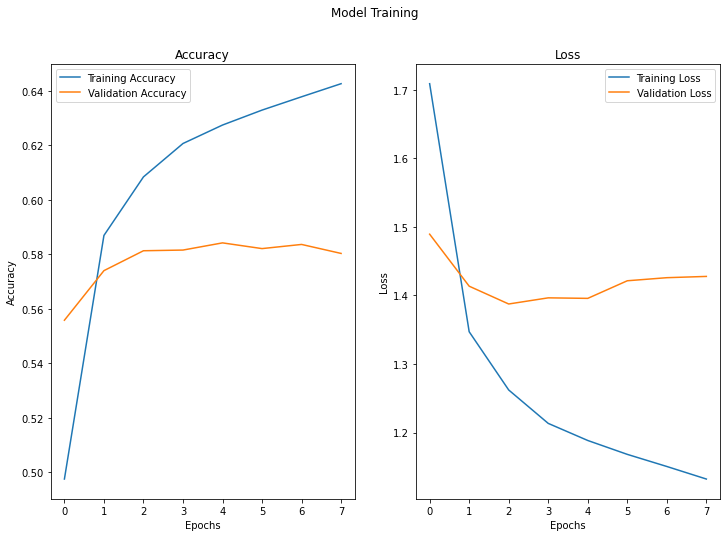

Saved Model Evaluation:
435/435 [==============================] - 15s 18ms/step - loss: 1.6201 - sparse_categorical_accuracy: 0.5416
New Model Evaluation:
435/435 [==============================] - 24s 41ms/step - loss: 1.5901 - sparse_categorical_accuracy: 0.5497
INFO:tensorflow:Assets written to: CharacterLSTM\assets


INFO:tensorflow:Assets written to: CharacterLSTM\assets


In [51]:
plot_training_metrics(char_history)
save_best_model(char_model, char_test_ds, 'Character_LSTM')

### Generating Text with the Best Model

In [52]:
length_to_generate = 2000
starting_string = 'And then'

best_model = tf.keras.models.load_model('Character_LSTM')
generated_text = starting_string
for i in range(length_to_generate):
    if len(generated_text) > char_sequence_length:
        prediction_string = generated_text[-char_sequence_length:]
    else:
        prediction_string = generated_text
    prediction_ids = tf.transpose(tf.expand_dims(char_encoder(list(prediction_string)), axis=1))
    predicted_logits = best_model(prediction_ids)
    predicted_index = tf.random.categorical(predicted_logits, num_samples=1)
    generated_text += char_decoder(predicted_index).numpy()[0][0].decode()

print('Generated Text:')
print(generated_text)

Generated Text:
And then; I would be not she
As mortalsy which: what's your honour's son?

DUKE VINCENTIO:
Was you been scope to be set we pardles their
bitters, noble lunation. I go believe me,
how met this grand that it shall have any unfurced'd my lord,
Wood of the duke's lord as your patience!
Give me the boys such sorrow much sent and gore;
We'll palt the bormed of fresh report,
Wicks, rings in a courtier's peace:
Nor much betime the curst of my perture.

DUKE VINCENTIO:
You thirty one that would I would use her
Look in the truth of Holy esure.
Percusmass thoughts all to the keen should be prosiplty.

TRANIO:
ETward this content?

DUKE VINCENTIO:
Q, no, not my mind be meet, my lord;
It is her to find behelless: I may burn?
But I should be not Velruman was cited citiem's offence.
O, come, let heal him again by gears that mark
The notislave than the colours that made remain;
What tast this bad?
Here's your gracelet.

LUCENTIO:
That must be look'd enough from hence that would,
Your u

## Word Based Approach

### Loading and Processing the Dataset

In [28]:
word_batch_size = 128
word_sequence_length = 25
word_vocab_size = 1000

AUTOTUNE = tf.data.AUTOTUNE

test_ds, train_ds, validation_ds = tfds.load('tiny_shakespeare', split=['test', 'train', 'validation'])

train_text = next(train_ds.as_numpy_iterator())['text'].decode()
word_encoder = tf.keras.layers.experimental.preprocessing.StringLookup(max_tokens=word_vocab_size)
word_encoder.adapt(re.findall(r"[\w']+|[.,!?;:\n]", train_text)) # This regex splits the text into words and punctuation
word_decoder = tf.keras.layers.experimental.preprocessing.StringLookup(
    invert=True,
    vocabulary=word_encoder.get_vocabulary()
)

def process_ds(ds):
    ds_text = next(ds.as_numpy_iterator())['text'].decode().lower()
    ds = tf.data.Dataset.from_tensor_slices(word_encoder(re.findall(r"[\w']+|[.,!?;:\n]", ds_text)))
    ds = ds.window(word_sequence_length+1, drop_remainder=True, shift=1)
    ds = ds.flat_map(lambda window: window.batch(word_sequence_length+1))
    ds = ds.map(lambda sequence: (sequence[:-1], sequence[-1]), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(word_batch_size)
    ds = ds.shuffle(1000)
    ds = ds.prefetch(AUTOTUNE)
    return ds

word_test_ds = process_ds(test_ds)
word_train_ds = process_ds(train_ds)
word_validation_ds = process_ds(validation_ds)

### Creating the Model

In [53]:
# Best Model
# word_model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(
#         input_dim=word_vocab_size,
#         output_dim=64
#     ),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
#     tf.keras.layers.Dense(word_vocab_size)
# ])

word_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=word_vocab_size,
        output_dim=64
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)),
    tf.keras.layers.Dense(word_vocab_size)
])
word_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam()
)

### Training the Model

In [54]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    mode='max',
    monitor='val_sparse_categorical_accuracy',
    patience=3,
    restore_best_weights=True
)
word_history = word_model.fit(
    word_train_ds,
    callbacks=[early_stopping_callback],
    epochs=100,
    validation_data=word_validation_ds
)

Epoch 1/100
2034/2034 [==============================] - 75s 31ms/step - loss: 3.7020 - sparse_categorical_accuracy: 0.3259 - val_loss: 3.2075 - val_sparse_categorical_accuracy: 0.3879
Epoch 2/100
2034/2034 [==============================] - 71s 31ms/step - loss: 3.3166 - sparse_categorical_accuracy: 0.3622 - val_loss: 3.0604 - val_sparse_categorical_accuracy: 0.3990
Epoch 3/100
2034/2034 [==============================] - 71s 30ms/step - loss: 3.1553 - sparse_categorical_accuracy: 0.3745 - val_loss: 2.9804 - val_sparse_categorical_accuracy: 0.4070
Epoch 4/100
2034/2034 [==============================] - 70s 30ms/step - loss: 3.0317 - sparse_categorical_accuracy: 0.3830 - val_loss: 2.9284 - val_sparse_categorical_accuracy: 0.4156
Epoch 5/100
2034/2034 [==============================] - 70s 31ms/step - loss: 2.8991 - sparse_categorical_accuracy: 0.3926 - val_loss: 2.9567 - val_sparse_categorical_accuracy: 0.4120
Epoch 6/100
2034/2034 [==============================] - 71s 30ms/step - lo

### Plotting Training Metrics and Saving the Best Model

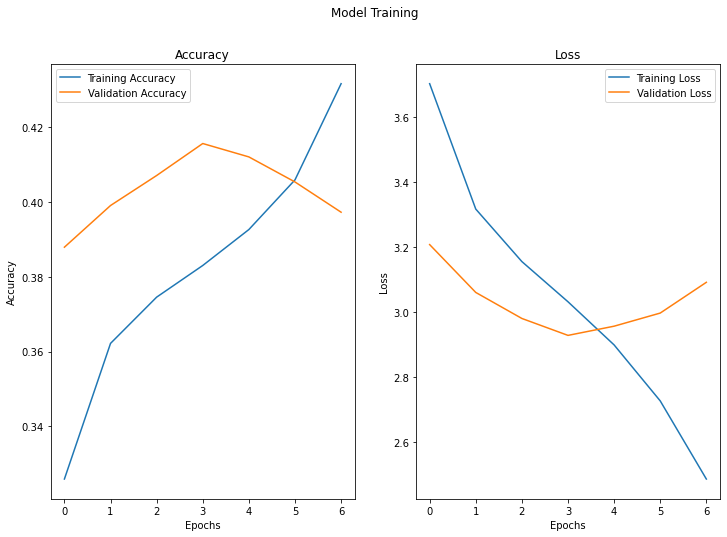

Saved Model Evaluation:
117/117 [==============================] - 3s 8ms/step - loss: 3.0241 - sparse_categorical_accuracy: 0.4113
New Model Evaluation:
117/117 [==============================] - 2s 12ms/step - loss: 2.9937 - sparse_categorical_accuracy: 0.4125
INFO:tensorflow:Assets written to: WordLSTM\assets


INFO:tensorflow:Assets written to: WordLSTM\assets


In [55]:
plot_training_metrics(word_history)
save_best_model(word_model, word_test_ds, 'Word_LSTM')

### Generating Text

In [56]:
length_to_generate = 500
starting_string = 'And then'

best_model = tf.keras.models.load_model('Word_LSTM')
generated_text = starting_string
for i in range(length_to_generate):
    if len(generated_text) > word_sequence_length:
        prediction_string = generated_text[-word_sequence_length:]
    else:
        prediction_string = generated_text
    prediction_ids = tf.transpose(tf.expand_dims(word_encoder(prediction_string.split()), axis=1))
    predicted_logits = best_model(prediction_ids)
    predicted_index = tf.random.categorical(predicted_logits, num_samples=1)
    word_to_add = word_decoder(predicted_index).numpy()[0][0].decode()
    if re.search(r'[.,!?;:\n]', word_to_add):
        generated_text += word_to_add
    else:
        generated_text += ' ' + word_to_add

print('Generated Text:')
print(generated_text)

Generated Text:
And then virtuous great [UNK]? for sorrow your highness!, [UNK]!,. deeds [UNK]. rest at
 kind and our [UNK] [UNK], to his [UNK] and
 a [UNK]
;


 and as we yourself, us and his [UNK],,,. [UNK], [UNK];?;
 murder these [UNK]!? give me up::? without eyes??.,,
 and [UNK]: in
 [UNK]., straight??. is [UNK] can beat my help: my heart,?
:


 at that side cannot [UNK] grief, Look?, doth [UNK]
 power; him,, course..; other late [UNK]; will beat
 [UNK] away all their [UNK] honour:!, with [UNK];, [UNK] mine: can an lawful
 grave dear [UNK],: of sin!;
,




 strike your father's mouth,
;










 and now [UNK] dead. from banishment and a [UNK] bid.;;!;?! of tears [UNK] myself turn on us
;
 from dangerous [UNK]

 love the [UNK] of [UNK] myself,.; [UNK] [UNK]. than we will bring thee hence on men from hence my [UNK] can speak: me. live a men [UNK].:
;

 and now, and lose them..! [UNK]!
.



 [UNK] [UNK]! not speak!:? dear [UNK] is [UNK] your [UNK].;;? truth!.
,



 [UNK], [UNK] your

On this task the character model seems to do better than the word model. Both are largely nonsensical but the character model less so. However, the word model may be limited by our limited vocabulary size of 1000 words. This doesn't excuse or explain its tendency to have multiple punctuation marks in a row, but may limit how effective training can be since many words in the training text will be represented by the [UNK] token.